In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

In [31]:
exchange="MC"
indiceName="ibex35"
getsectors=True
getdescriptions=False
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
not_index=True
tamMinimo=50
mod=4
nivel_confianza=0.05
numberPreds=10

In [3]:
bd=bdStocks.getData()
precios=bd.getPrizesByExchange(exchange,columnas=columnasPrecios)
fundamentals=bd.getFundamentalsByExchange(exchange,bd=True,columnas=columnas)
indice=bd.getIndexPrizes(indiceName)
if getsectors:
    sectors=bd.getSectors(exchange)
    fundamentals["sector"]=fundamentals["stock"].transform(lambda t:sectors[t])
if   getdescriptions:
    descriptions=bd.getDescriptions(exchange)
    fundamentals["description"]=fundamentals["stock"].transform(lambda t:descriptions[t])
if not_index:
    precios.reset_index(inplace=True)
    fundamentals.reset_index(inplace=True)

Time: 03/03/2022, 21:23 Message: CSV access time to get prizes 3.249131917953491

Time: 03/03/2022, 21:23 Message: Object size (prizes data)63.440014 MB

Time: 03/03/2022, 21:23 Message: BD access time to get stock fundamentals 0.49419593811035156

Time: 03/03/2022, 21:23 Message: Object size (fundamental data)8.026913 MB

Time: 03/03/2022, 21:23 Message: BD access time to sectors 0.2282116413116455



In [59]:
import itertools

sectors=np.unique(fundamentals["sector"])
dataframeAnalysis=fundamentals.loc[fundamentals["sector"].isin([sectors[-6]])]
stocks=[e for e in np.unique(dataframeAnalysis["stock"]) if (dataframeAnalysis.loc[dataframeAnalysis["stock"]==e]).shape[0]>tamMinimo]
print(stocks)
stocks=iter(stocks)
dataframeAnalysis.shape

['ALB', 'BBVA', 'BKT', 'CABK', 'GCO', 'MAP', 'SAN', 'UNI']


(668, 5)

Stock ALB
(75, 1)


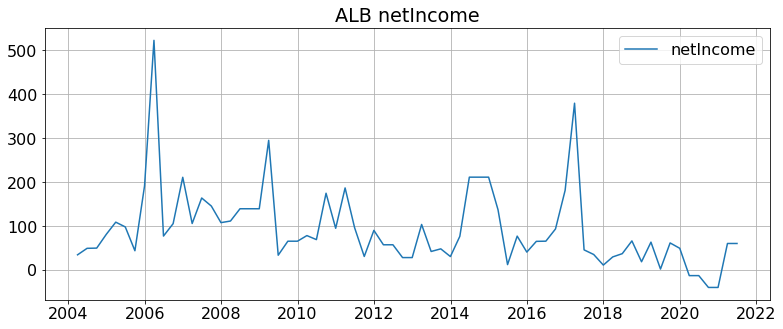

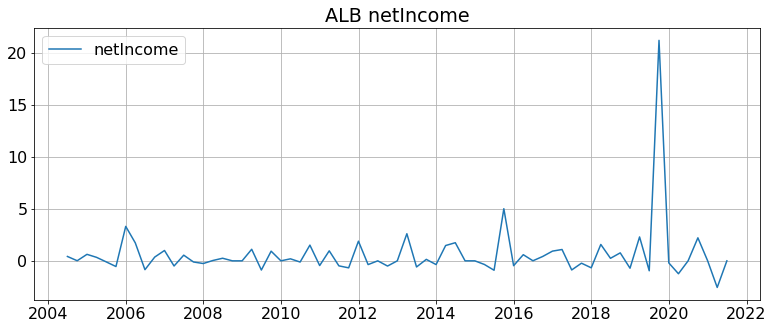

In [60]:
stock=next(stocks)
print("Stock %s"%stock)
column="netIncome"
data=dataframeAnalysis.loc[dataframeAnalysis["stock"]==stock,["fecha",column]]
data.set_index("fecha",inplace=True,drop=True)
print(data.shape)
data=data.fillna(method='ffill')/1000000
data=data.dropna()
graficos.linearplot(data,stock+" "+column,False,column)
graficos.linearplot(data.pct_change(),stock+" "+column,False,column)

-39.05


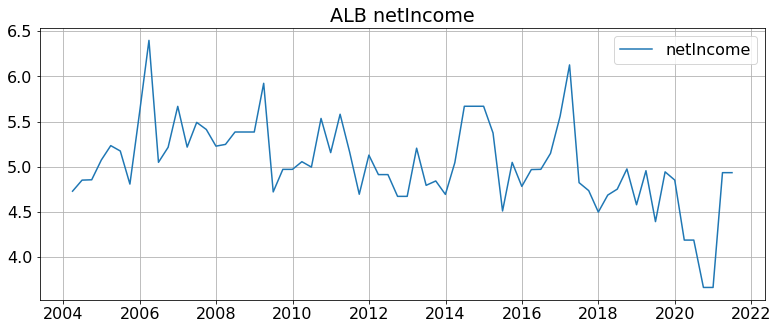

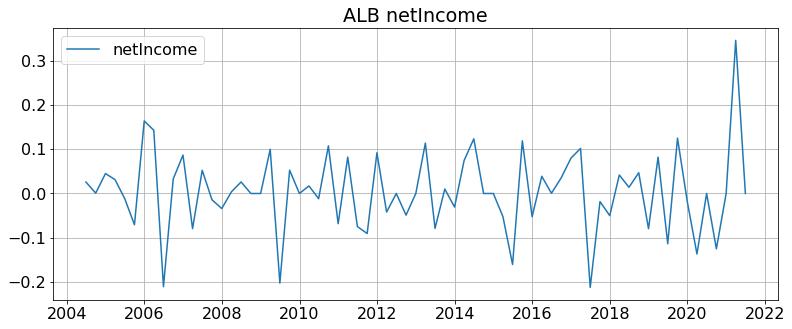

-39.05


In [61]:
import math
import transformations
minimo=np.min(data)[0]
if minimo<0:
    print(minimo)
    data=data-minimo*2
boxcox=transformations.boxcox
data1=(data).applymap(lambda x:(boxcox(0,x)))
graficos.linearplot(data1,stock+" "+column,False,column)
graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
print(minimo)
serie=data1[column]


In [62]:
from statsmodels.tsa.stattools import adfuller
#la hipotesis nula es que hay raiz unitaria
adf=adfuller(serie,maxlag=1)
adf

(-4.62666238166495,
 0.00011531617623140897,
 0,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 74.57119252087105)

[ 1.          0.51815131  0.31894014  0.22537376  0.09203049  0.11877494
  0.16403783  0.05914575  0.18019651  0.18218609  0.18790149  0.12662503
  0.06666461 -0.09292964 -0.14916825 -0.11393621 -0.01057828 -0.07036628
 -0.02465448 -0.04506811 -0.00240398  0.01935459 -0.05033187 -0.06665209
 -0.02566304 -0.08496374 -0.03233063 -0.01683642  0.03529829  0.04124303
  0.03866815]
[ 1.          0.52566075  0.07185697  0.0520997  -0.08220791  0.1142055
  0.10917669 -0.11416318  0.22636738  0.03205801  0.10334283 -0.11218656
 -0.00197423 -0.23988369 -0.14160397  0.05083144  0.12992734 -0.18676276
  0.01693639 -0.00644924  0.09912113  0.00240158 -0.08795649  0.13622024
  0.01609886 -0.08695398 -0.00921276  0.02138084  0.12344502 -0.0378485
  0.03790634]


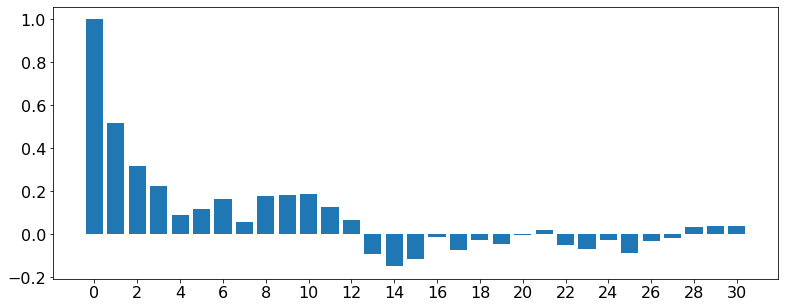

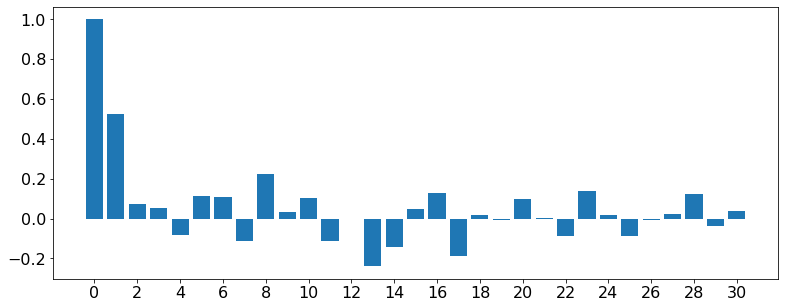

In [63]:
nlags=30
diferenciacion=0
from statsmodels.tsa.stattools import acf
corr=acf(serie,nlags=nlags)
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
pcorr=pacf(serie,nlags=nlags)
print(corr)
print(pcorr)
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
modelo=select_order(serie)
graficos.correlograma(corr,pcorr)


In [64]:
print("Autocorrelacion %s"%(np.where(corr>np.mean(corr)+0.25*np.std(corr))[0]))
print("Autocorrelacion  modulo %s %s"%(np.where(corr>np.mean(corr)+0.25*np.std(corr))[0]%mod,mod))
print("Autocorrelacion %s"%(np.where(pcorr>np.mean(pcorr)+0.25*np.std(pcorr))[0]))
print("Autocorrelacion parcial modulo %s %s"%(np.where(pcorr>np.mean(pcorr)+0.25*np.std(pcorr))[0]%mod,mod))

Autocorrelacion [ 0  1  2  3  6  8  9 10]
Autocorrelacion  modulo [0 1 2 3 2 0 1 2] 4
Autocorrelacion [ 0  1  5  8 16 23 28]
Autocorrelacion parcial modulo [0 1 1 0 0 3 0] 4


In [65]:
from scipy.stats import norm
import math
#True es que se acepta y False que se rechaza
def contrasteCoeficientes(corr,pcorr,diferenciacion,nivelConfianza):
    T=len(corr)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivelConfianza/2)
    a= abs(corr)/desv<nivel
    b= a= abs(pcorr)/desv<nivel
    return a,b
    
    
corrAcept,pcorrAcept=contrasteCoeficientes(corr,pcorr,diferenciacion,nivel_confianza)   
print(np.where( corrAcept==False)[0])
print(np.where( pcorrAcept==False)[0])
n=len(np.where( corrAcept==False)[0])
p=n-1
q=len(np.where( pcorrAcept==False)[0])-1
p,q
ordenes=(p,diferenciacion,q)

[0 1]
[0 1]


In [66]:

from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import acf
from scipy.stats import t
def contrasteMedia0(serie,diferenciacion,nivel_confianza):
    autocorrelaciones=acf(serie)
    T=len(corr)-diferenciacion
    varianzaMuestral=acovf(serie,adjusted=True,fft=False,nlag=len(corr))[0]
  
    varianza=varianzaMuestral/T*np.sum(1+2*autocorrelaciones[1:n])
    
    mediaMuestral=np.mean(serie)
    print(mediaMuestral)
    estadistico=mediaMuestral/varianza
    nivelCritico=t.ppf(1-nivel_confianza/2,T-1)
    print("Estadistico %s"%estadistico)
    print("Nivel critico %s"%nivelCritico)
    return (estadistico<nivelCritico)
    
contrasteMedia0(serie,diferenciacion,nivel_confianza)
contrasteMedia0(serie-np.mean(serie),diferenciacion,nivel_confianza)    



5.033536765625545
Estadistico 346.1373998671558
Nivel critico 2.0422724563012373
-3.2989484160290367e-16
Estadistico -2.2685628022392205e-14
Nivel critico 2.0422724563012373


True

In [67]:
#estimacion de los parametros
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
dataframeModelo=pd.DataFrame(serie)
modelo=ARIMA(endog=dataframeModelo,order=ordenes,trend="c")
#modelo=sm.tsa.statespace.SARIMAX(endog=dataframeModelo,order=ordenes,trend="c")
#modelo=ARMA(endog=dataframeModelo,order=ordenes,freq=dataframeModelo.index.inferred_freq)
dataframeModelo
modeloAjustado=modelo.fit()
modeloAjustado.specification
modeloAjustado.param_terms
modeloAjustado.cov_params()
modeloAjustado.summary()
print("P-Values %s"%(modeloAjustado.pvalues))
print("Shapiro %s"%(scipy.stats.shapiro(modeloAjustado.resid)[1]))
print("LillieFors %s"%(statsmodels.stats.diagnostic.lilliefors(modeloAjustado.resid)[0]))
def contrasteCorrelacionResiduos(serie,diferenciacion,nivelConfianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivelConfianza/2)
    a= abs(serie)/desv<nivel
   
    return a

contrasteCorrelacionResiduos(acf(modeloAjustado.resid),diferenciacion,nivel_confianza)

P-Values const     0.000000e+00
ar.L1     2.241346e-03
ma.L1     5.871209e-01
sigma2    2.149262e-09
dtype: float64
Shapiro 0.5017577409744263
LillieFors 0.07681015755716347


/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'
/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'
/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

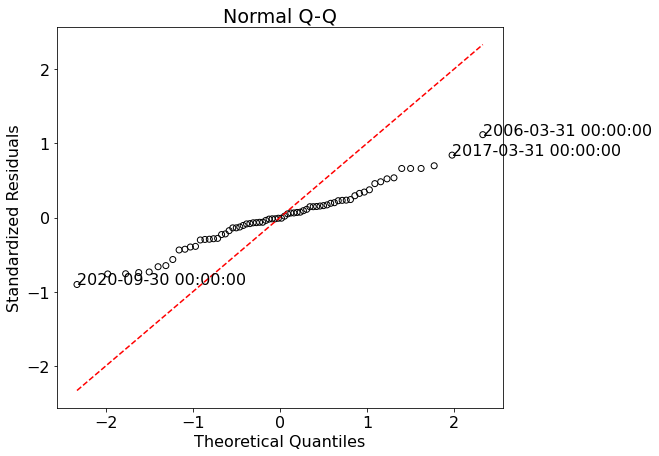

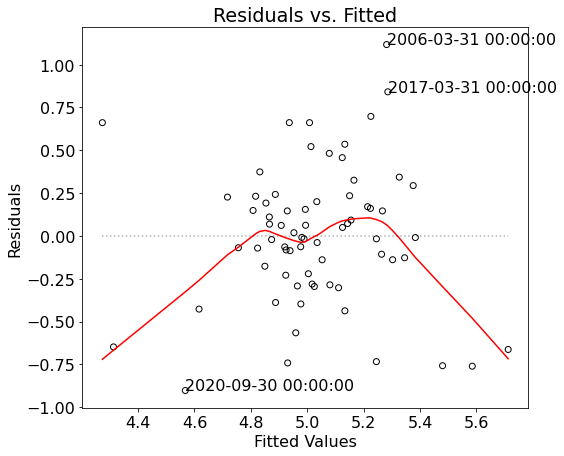

In [68]:
import scipy.stats
import statsmodels.stats.diagnostic
graficos.qqplot(modeloAjustado)
graficos.residualsVSfitted(modeloAjustado)


In [84]:
dataframePred=modeloAjustado.get_forecast(numberPreds).summary_frame()
media=dataframePred.loc[:,"mean"]
mediaInf=dataframePred.loc[:,"mean_ci_lower"]
mediaUpper=dataframePred.loc[:,"mean_ci_upper"]
pred=pd.concat([serie,media],axis=0)[-numberPreds*3:]



In [70]:

ar=modeloAjustado.params["ar.L1"]
ma=modeloAjustado.params["ma.L1"]
const=modeloAjustado.params["const"]
sigma2=modeloAjustado.params["sigma2"]
const*(1-ar)+ ar*(serie[-1]) +ma*modeloAjustado.resid[-1],modeloAjustado.params,modeloAjustado.get_prediction(start=70, dynamic=False).predicted_mean,modeloAjustado.get_forecast(1).summary_frame()


(4.957876346262133,
 const     5.025087
 ar.L1     0.626454
 ma.L1    -0.155037
 sigma2    0.160602
 dtype: float64,
 2021-09-30    4.957876
 Freq: Q-DEC, dtype: float64,
 netIncome       mean   mean_se  mean_ci_lower  mean_ci_upper
 2021-09-30  4.957876  0.400751       4.172418       5.743334)

In [71]:
serie=serie.map(lambda x:(math.exp(x)-minimo))
dataframePred=dataframePred.applymap(lambda x:(math.exp(x)-minimo))

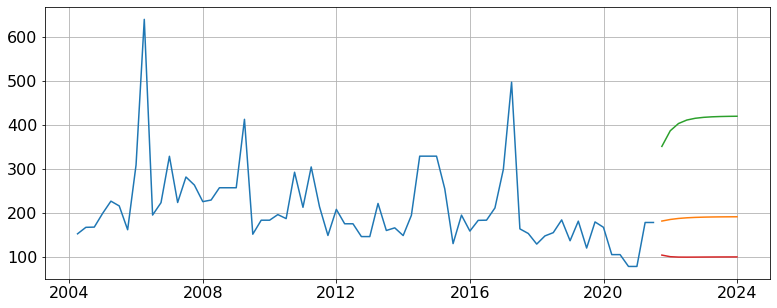

In [72]:

import matplotlib.pyplot as plt
import seaborn
import math
import numpy as np
import matplotlib.dates as mdates
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats
from pydataset import data
fig=plt.figure(figsize=(13,5))
plt.grid(True)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])

ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))


ax1.plot(serie.index,serie)
for k in ("mean","mean_ci_upper","mean_ci_lower"):
    ax1.plot(dataframePred.index,dataframePred.loc[:,k])

In [85]:
dataframePred


netIncome,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-30,4.957876,0.400751,4.172418,5.743334
2021-12-31,4.982983,0.443049,4.114622,5.851343
2022-03-31,4.998710,0.458584,4.099902,5.897519
2022-06-30,5.008563,0.464539,4.098084,5.919042
2022-09-30,5.014735,0.466855,4.099717,5.929754
2022-12-31,5.018602,0.467761,4.101808,5.935396
2023-03-31,5.021024,0.468116,4.103535,5.938514
2023-06-30,5.022542,0.468255,4.104779,5.940305
2023-09-30,5.023493,0.468310,4.105623,5.941362
2023-12-31,5.024088,0.468331,4.106176,5.942000


In [90]:
dataframePred.iloc[0,0]-math.sqrt(modeloAjustado.params["sigma2"])*norm.ppf(1-nivel_confianza/2)

4.17241826635946